<a href="https://colab.research.google.com/github/kowshik27/Customer-Attrition-Project/blob/main/Customer_Attrition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing all required packages

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.preprocessing import OneHotEncoder, LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.utils import class_weight
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score


from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

!pip install catboost
from catboost import CatBoostClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Reading the Data

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/Dataset project/train.csv")

remove = True
remove_features = ['MobileService','HardwareSupport','Married','sex']

catg_features = ['Aged','TotalDependents','4GService','CyberProtection','TechnicalAssistance','FilmSubscription','SettlementProcess']
numercl_features = ["QuarterlyPayment", "GrandPayment",'ServiceSpan']
label = ["CustomerAttrition"]
id_col = ["ID"]

if remove:
    dataset = dataset.drop(remove_features,axis = 1)
else:
    catg_features.extend(remove_features)
        

label_dict = {
    "Yes" : 1,
    "No" : 0
}
N_SPLITS = 9
dataset.head()

,ID,Aged,TotalDependents,ServiceSpan,4GService,CyberProtection,TechnicalAssistance,FilmSubscription,SettlementProcess,QuarterlyPayment,GrandPayment,CustomerAttrition
0,B60LHTZLLPFU4IULNPUF,No,Yes,48,Wifi Broadband,No,Yes,No,Check,96.259802,4628.129119,Yes
1,1RUJ7ONYZHYTWKOKO1SD,No,No,45,Wifi Broadband,No,No,Yes,Bank,18.876470,922.085998,No
2,DZ9EEOQWSN0MYCBUPAM5,Yes,No,59,Wifi Broadband,Yes,Yes,No,Card,106.016057,6205.891129,Yes
3,YZ43L1UQUQACTL1PXXZG,No,No,14,Wifi Broadband,No,No,No,Check,80.108839,1248.655391,No
4,6P28152QGF60PDLSCB9M,No,Yes,25,Wifi Broadband,No,No,Yes,Check,51.529773,1285.321277,No


## Data Preprocessing

In [ ]:
numercl_encoder = MinMaxScaler()

def preprocess_df(df, catg_features, numercl_features, data = "train"):
    for col in catg_features:
        if data == "train":
            cat_encoder = LabelEncoder()
            df[col] = cat_encoder.fit_transform(df[col])
            cat_encoder[col] = cat_encoder
        else:
            df[col] = cat_encoder[col].transform(df[col])
            
    if data == "train":
        df[numercl_features] = numercl_encoder.fit_transform(df[numercl_features])
    else:
        df[numercl_features] = numercl_encoder.transform(df[numercl_features])
    return df

In [ ]:
dataset[label[0]] = dataset[label[0]].map(label_dict)

dataset = preprocess_df(dataset, catg_features, numercl_features, data = "train")

labels = dataset[label[0]]
train_ds = dataset.drop(label + id_col, axis = 1)
tot_features = list(train_ds.columns)
cat_ids = []

for i, col in enumerate(tot_features):
    if col in catg_features:
        cat_ids.append(i)
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(labels.values),
                                                 y = labels.values)
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6338 entries, 0 to 6337
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Aged                 6338 non-null   int64  
 1   TotalDependents      6338 non-null   int64  
 2   ServiceSpan          6338 non-null   float64
 3   4GService            6338 non-null   int64  
 4   CyberProtection      6338 non-null   int64  
 5   TechnicalAssistance  6338 non-null   int64  
 6   FilmSubscription     6338 non-null   int64  
 7   SettlementProcess    6338 non-null   int64  
 8   QuarterlyPayment     6338 non-null   float64
 9   GrandPayment         6328 non-null   float64
dtypes: float64(3), int64(7)
memory usage: 495.3 KB


In [ ]:
train_ds =train_ds.fillna(method='bfill')
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6338 entries, 0 to 6337
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Aged                 6338 non-null   int64  
 1   TotalDependents      6338 non-null   int64  
 2   ServiceSpan          6338 non-null   float64
 3   4GService            6338 non-null   int64  
 4   CyberProtection      6338 non-null   int64  
 5   TechnicalAssistance  6338 non-null   int64  
 6   FilmSubscription     6338 non-null   int64  
 7   SettlementProcess    6338 non-null   int64  
 8   QuarterlyPayment     6338 non-null   float64
 9   GrandPayment         6338 non-null   float64
dtypes: float64(3), int64(7)
memory usage: 495.3 KB


In [ ]:
train_ds

,Aged,TotalDependents,ServiceSpan,4GService,CyberProtection,TechnicalAssistance,FilmSubscription,SettlementProcess,QuarterlyPayment,GrandPayment
0,0,1,0.666667,2,0,1,0,2,0.769434,0.531957
1,0,0,0.626667,2,0,0,1,0,0.022887,0.104479
2,1,0,0.813333,2,1,1,0,1,0.863556,0.713946
3,0,0,0.213333,2,0,0,0,2,0.613619,0.142148
4,0,1,0.360000,2,0,0,1,2,0.337906,0.146377
...,...,...,...,...,...,...,...,...,...,...
6333,1,0,0.066667,2,0,0,1,1,0.809294,0.049093
6334,1,0,0.013333,1,0,0,1,0,0.272809,0.003346
6335,0,1,0.266667,0,0,0,0,3,0.187522,0.061812
6336,0,0,0.640000,0,0,0,1,1,0.754993,0.524539


In [ ]:
roc_scores = np.zeros((N_SPLITS*4))
test_pred = {}
num = 0

In [58]:
X = train_ds
y = labels
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y, test_size = 0.20,shuffle= False)

0       1
1       0
2       1
3       0
4       0
       ..
5065    0
5066    1
5067    0
5068    1
5069    0
Name: CustomerAttrition, Length: 5070, dtype: int64

In [74]:
print(Xtest.shape)

(1268, 10)


## CatBoost

In [59]:
SEED = 143
kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
count = 0
cb_best = 0
feature_imp_cb = 0
cb_score = 0
roc_cb_scores = np.zeros((N_SPLITS))
cb_pred = {}

for train_idx,test_idx in kfold.split(Xtrain,ytrain):
    print(' Running {} of KFold {}'.format(count+1,kfold.n_splits))
    xtr,xvl = Xtrain.loc[train_idx],Xtrain.loc[test_idx]
    ytr,yvl = ytrain.loc[train_idx],ytrain.loc[test_idx]
    
    cb_model = CatBoostClassifier(
                        verbose=100,
                        eval_metric="Accuracy",
                        loss_function="Logloss",
                        random_state=2021,
                        num_boost_round=20000,
                        od_type="Iter",
                        od_wait=200,
                        cat_features=cat_ids,
                        bagging_temperature=1.288692494969795,
                        grow_policy="Depthwise",
                        l2_leaf_reg=9.847870133539244,
                        learning_rate=0.01877982653902465,
                        max_depth=8,
                        min_data_in_leaf=1,
                        penalties_coefficient=2.1176668909602734,
            )
    cb_model.fit(xtr,ytr,eval_set=(xvl,yvl))
    cb_best += cb_model.predict_proba(Xtest)
    cb_pred[count] = cb_model.predict_proba(Xtest)
    
    roc_cb_scores[count] = roc_auc_score(yvl,cb_model.predict_proba(xvl)[:,-1], average="macro")
    cb_score += roc_auc_score(yvl,cb_model.predict_proba(xvl)[:,-1], average="macro")
    
    print("CB - ROC AUC Score = {}".format(roc_auc_score(yvl,cb_model.predict_proba(xvl)[:,-1], average="macro")))
    feature_imp_cb += cb_model.feature_importances_
    
    roc_scores[num*N_SPLITS + count] = roc_auc_score(yvl,cb_model.predict_proba(xvl)[:,-1], average="macro")
    test_pred[num*N_SPLITS + count] = cb_model.predict_proba(Xtest)
    count+=1

cb_score = cb_score/N_SPLITS
cb_best = cb_best/N_SPLITS
feature_imp_cb = list(feature_imp_cb/N_SPLITS)
num +=1

 Running 1 of KFold 9
0:	learn: 0.8018198	test: 0.7996454	best: 0.7996454 (0)	total: 18.1ms	remaining: 6m 2s
100:	learn: 0.8200178	test: 0.8049645	best: 0.8138298 (11)	total: 1.49s	remaining: 4m 53s
200:	learn: 0.8315579	test: 0.8085106	best: 0.8156028 (168)	total: 2.88s	remaining: 4m 43s
300:	learn: 0.8375499	test: 0.8120567	best: 0.8156028 (168)	total: 4.2s	remaining: 4m 34s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8156028369
bestIteration = 168

Shrink model to first 169 iterations.
CB - ROC AUC Score = 0.8306912681912683
 Running 2 of KFold 9
0:	learn: 0.8058145	test: 0.7836879	best: 0.7836879 (0)	total: 16ms	remaining: 5m 19s
100:	learn: 0.8226809	test: 0.8049645	best: 0.8102837 (7)	total: 1.42s	remaining: 4m 39s
200:	learn: 0.8320018	test: 0.8031915	best: 0.8102837 (7)	total: 2.77s	remaining: 4m 32s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8102836879
bestIteration = 7

Shrink model to first 8 iterations.
CB - ROC AUC Score =

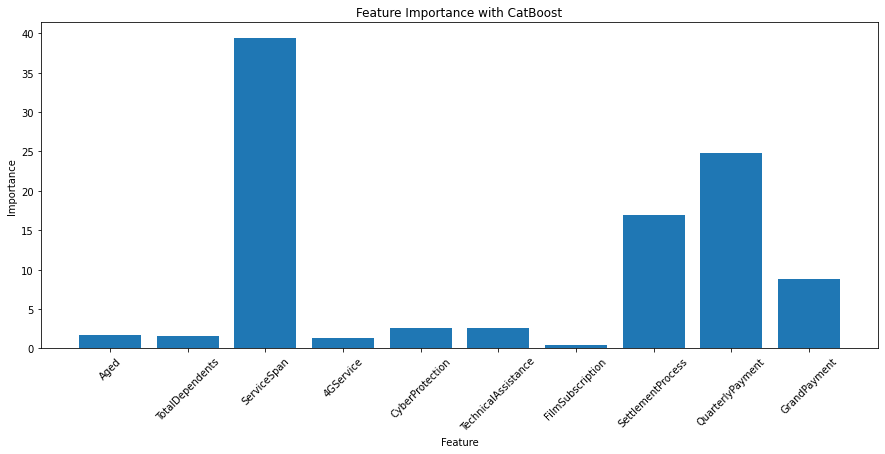

In [60]:
#Feature Importances

plt.figure(figsize = (15,6))
plt.bar(tot_features,feature_imp_cb)
plt.title("Feature Importance with CatBoost")
plt.xlabel("Feature")
plt.xticks(rotation = 45)
plt.ylabel("Importance")
plt.show()

In [61]:
count = 0
lgb_best = 0
feature_imp_lgb = 0
lgb_score = 0
roc_lgb_scores = np.zeros((N_SPLITS))
lgb_pred = {}

for train_idx,test_idx in kfold.split(Xtrain,ytrain):
    print(' Running {} of KFold {}'.format(count+1,kfold.n_splits))
    xtr,xvl = Xtrain.loc[train_idx],Xtrain.loc[test_idx]
    ytr,yvl = ytrain.loc[train_idx],ytrain.loc[test_idx]

    lgb_model = LGBMClassifier(
               n_estimators = 1000,
               cat_feature=cat_ids,
               metric = "auc"
    )
    
    lgb_model.fit(xtr,ytr,eval_set=[(xvl,yvl)], verbose = 500)
    lgb_best += lgb_model.predict_proba(Xtest)
    lgb_pred[count] = lgb_model.predict_proba(Xtest)
    
    roc_lgb_scores[count] = roc_auc_score(yvl,lgb_model.predict_proba(xvl)[:,-1], average="macro")
    lgb_score += roc_auc_score(yvl,lgb_model.predict_proba(xvl)[:,-1], average="macro")
    print("LGB - ROC AUC Score = {}".format(roc_auc_score(yvl,lgb_model.predict_proba(xvl)[:,-1], average="macro")))
    feature_imp_lgb += lgb_model.feature_importances_
    
    roc_scores[num*N_SPLITS + count] = roc_auc_score(yvl,lgb_model.predict_proba(xvl)[:,-1], average="macro")
    test_pred[num*N_SPLITS + count] = lgb_model.predict_proba(Xtest)
    count+=1

lgb_score = lgb_score/N_SPLITS
lgb_best = lgb_best/N_SPLITS
feature_imp_lgb = list(feature_imp_lgb/N_SPLITS)
num+=1

 Running 1 of KFold 9
[500]	valid_0's auc: 0.807774
[1000]	valid_0's auc: 0.797915
LGB - ROC AUC Score = 0.797914501039501
 Running 2 of KFold 9
[500]	valid_0's auc: 0.807302
[1000]	valid_0's auc: 0.793935
LGB - ROC AUC Score = 0.793935161122661
 Running 3 of KFold 9
[500]	valid_0's auc: 0.787174
[1000]	valid_0's auc: 0.77153
LGB - ROC AUC Score = 0.7715297150035074
 Running 4 of KFold 9
[500]	valid_0's auc: 0.805861
[1000]	valid_0's auc: 0.799892
LGB - ROC AUC Score = 0.7998920722135008
 Running 5 of KFold 9
[500]	valid_0's auc: 0.784848
[1000]	valid_0's auc: 0.781463
LGB - ROC AUC Score = 0.7814625850340137
 Running 6 of KFold 9
[500]	valid_0's auc: 0.824225
[1000]	valid_0's auc: 0.81595
LGB - ROC AUC Score = 0.81595041862899
 Running 7 of KFold 9
[500]	valid_0's auc: 0.822868
[1000]	valid_0's auc: 0.807856
LGB - ROC AUC Score = 0.8078558346415489
 Running 8 of KFold 9
[500]	valid_0's auc: 0.774529
[1000]	valid_0's auc: 0.769411
LGB - ROC AUC Score = 0.7694106488749345
 Running 9 of 

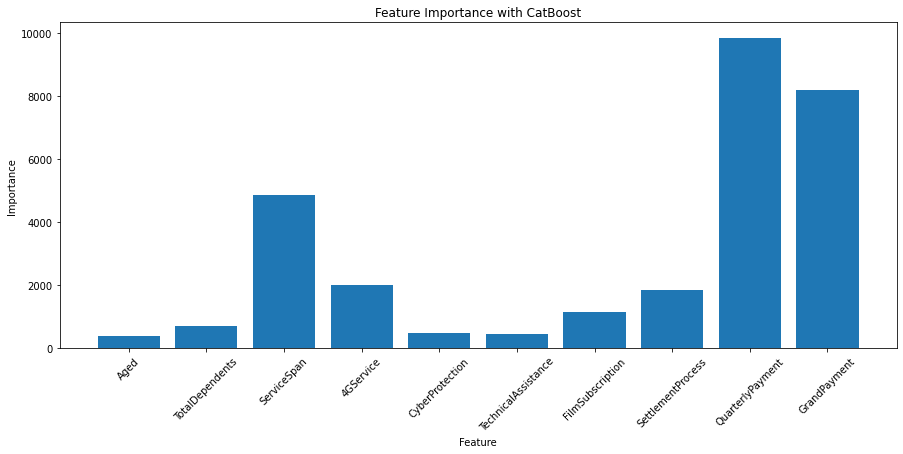

In [62]:
#Feature Importances

plt.figure(figsize = (15,6))
plt.bar(tot_features,feature_imp_lgb)
plt.title("Feature Importance with LightGBM")
plt.xlabel("Feature")
plt.xticks(rotation = 45)
plt.ylabel("Importance")
plt.show()

In [63]:
count = 0
xgb_best = 0
feature_imp_xgb = 0
xgb_score = 0
roc_xgb_scores = np.zeros((N_SPLITS))
xgb_pred = {}

for train_idx,test_idx in kfold.split(Xtrain,ytrain):
    print(' Running {} of KFold {}'.format(count+1,kfold.n_splits))
    xtr,xvl = Xtrain.loc[train_idx],Xtrain.loc[test_idx]
    ytr,yvl = ytrain.loc[train_idx],ytrain.loc[test_idx]
    
    xgb_model = XGBClassifier(
               use_label_encoder = False,
               eval_metric = "auc"
    )
    xgb_model.fit(xtr,ytr,eval_set=[(xvl,yvl)], verbose = 500)
    xgb_best += xgb_model.predict_proba(Xtest)
    xgb_pred[count] = xgb_model.predict_proba(Xtest)
    
    roc_xgb_scores[count] = roc_auc_score(yvl,xgb_model.predict_proba(xvl)[:,-1], average="macro")
    xgb_score += roc_auc_score(yvl,xgb_model.predict_proba(xvl)[:,-1], average="macro")
    print("XGB - ROC AUC Score = {}".format(roc_auc_score(yvl,xgb_model.predict_proba(xvl)[:,-1], average="macro")))
    feature_imp_xgb += np.array(list(xgb_model.get_booster().get_score(importance_type='weight').values()))
    
    roc_scores[num*N_SPLITS + count] = roc_auc_score(yvl,xgb_model.predict_proba(xvl)[:,-1], average="macro")
    test_pred[num*N_SPLITS + count] = xgb_model.predict_proba(Xtest)
    count+=1
    
xgb_score = xgb_score/N_SPLITS
xgb_best = xgb_best/N_SPLITS
feature_imp_xgb = list(feature_imp_xgb/N_SPLITS)
num+=1

 Running 1 of KFold 9
[0]	validation_0-auc:0.764829
[99]	validation_0-auc:0.829571
XGB - ROC AUC Score = 0.8295705561330561
 Running 2 of KFold 9
[0]	validation_0-auc:0.811525
[99]	validation_0-auc:0.847608
XGB - ROC AUC Score = 0.8476075233887734
 Running 3 of KFold 9
[0]	validation_0-auc:0.778112
[99]	validation_0-auc:0.816946
XGB - ROC AUC Score = 0.8169464428457235
 Running 4 of KFold 9
[0]	validation_0-auc:0.744644
[99]	validation_0-auc:0.835394
XGB - ROC AUC Score = 0.8353937728937729
 Running 5 of KFold 9
[0]	validation_0-auc:0.752167
[99]	validation_0-auc:0.81317
XGB - ROC AUC Score = 0.8131704604918891
 Running 6 of KFold 9
[0]	validation_0-auc:0.770629
[99]	validation_0-auc:0.856047
XGB - ROC AUC Score = 0.8560472265829409
 Running 7 of KFold 9
[0]	validation_0-auc:0.813996
[99]	validation_0-auc:0.850904
XGB - ROC AUC Score = 0.8509043040293041
 Running 8 of KFold 9
[0]	validation_0-auc:0.726076
[99]	validation_0-auc:0.804495
XGB - ROC AUC Score = 0.8044953558346415
 Running 

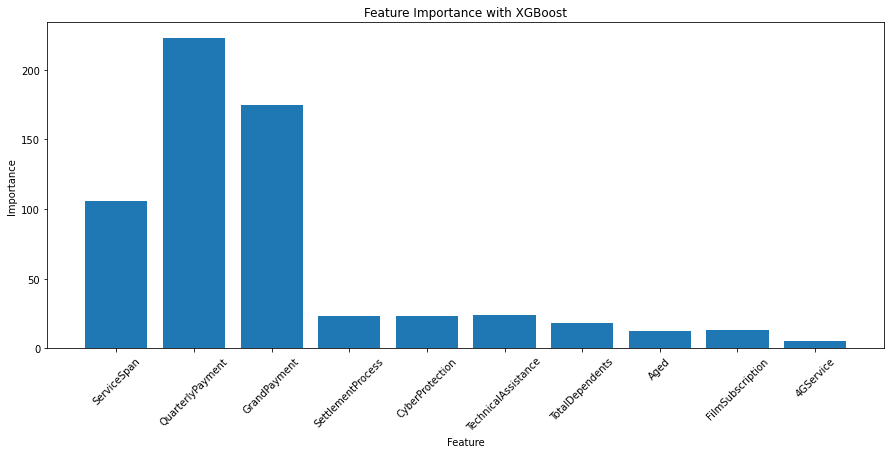

In [65]:
#Feature Importances

features = list(xgb_model.get_booster().get_score(importance_type='weight').keys())
plt.figure(figsize = (15,6))
plt.bar(features,feature_imp_xgb)
plt.title("Feature Importance with XGBoost")
plt.xlabel("Feature")
plt.xticks(rotation = 45)
plt.ylabel("Importance")
plt.show()

In [66]:
count = 0
hgb_best = 0
hgb_score = 0
roc_hgb_scores = np.zeros((N_SPLITS))
hgb_pred = {}

for train_idx,test_idx in kfold.split(Xtrain,ytrain):
    print(' Running {} of KFold {}'.format(count+1,kfold.n_splits))
    xtr,xvl = Xtrain.loc[train_idx],Xtrain.loc[test_idx]
    ytr,yvl = ytrain.loc[train_idx],ytrain.loc[test_idx]
    
    hgb_model = HistGradientBoostingClassifier(
                    l2_regularization=1.766059063693552,
                    learning_rate=0.10675193678150449,
                    max_bins=128,
                    max_depth=31,
                    max_leaf_nodes=185,
                    random_state=2021,
                    verbose = 0
            )
    hgb_model.fit(xtr,ytr)
    
    roc_hgb_scores[count] = roc_auc_score(yvl,hgb_model.predict_proba(xvl)[:,-1], average="macro")
    hgb_score += roc_auc_score(yvl,hgb_model.predict_proba(xvl)[:,-1], average="macro")
    print("HGB - ROC AUC Score = {}".format(roc_auc_score(yvl,hgb_model.predict_proba(xvl)[:,-1], average="macro")))
    hgb_best += hgb_model.predict_proba(Xtest)
    hgb_pred[count] = hgb_model.predict_proba(Xtest)
    
    roc_scores[num*N_SPLITS + count] = roc_auc_score(yvl,hgb_model.predict_proba(xvl)[:,-1], average="macro")
    test_pred[num*N_SPLITS + count] = hgb_model.predict_proba(Xtest)
    count+=1

hgb_score = hgb_score/N_SPLITS
hgb_best = hgb_best/N_SPLITS

 Running 1 of KFold 9
HGB - ROC AUC Score = 0.7920835498960499
 Running 2 of KFold 9
HGB - ROC AUC Score = 0.8203774688149688
 Running 3 of KFold 9
HGB - ROC AUC Score = 0.7871580286790976
 Running 4 of KFold 9
HGB - ROC AUC Score = 0.7954277864992152
 Running 5 of KFold 9
HGB - ROC AUC Score = 0.7830487964416535
 Running 6 of KFold 9
HGB - ROC AUC Score = 0.8287872841444269
 Running 7 of KFold 9
HGB - ROC AUC Score = 0.8213631606488749
 Running 8 of KFold 9
HGB - ROC AUC Score = 0.776229722658294
 Running 9 of KFold 9
HGB - ROC AUC Score = 0.7970630559916274


In [68]:
print("Final XGB score : ",xgb_score)
print("Final LGB score : ",lgb_score)
print("Final CB score : ",cb_score)
print("Final HGB score : ",hgb_score)

Final XGB score :  0.8299514193990577
Final LGB score :  0.7900429815549506
Final CB score :  0.8230897566821684
Final HGB score :  0.8001709837526898


In [85]:
#pred_test_full = (cb_best + xgb_best + hgb_best + lgb_best) / 4
#pred_test_full = cb_best

pred_test_full = 0
top = 5
indices = np.argpartition(roc_scores, -1*top)[-1*top:]

for i in indices:
    pred_test_full += test_pred[i]
    print("Considering model with ROC: ",roc_scores[i])
pred_test_full = pred_test_full/top

label_dict = {
    1 : "Yes" ,
    0 : "No"
}
pred = [label_dict[np.argmax(i)] for i in pred_test_full]

predictions = {
    label[0] : pred
}

dict_rev = {
    "Yes": 1  ,
    "No":0
}


pred_df = pd.DataFrame.from_dict(predictions)
print(pred_df[label[0]].value_counts())
pred_df['CustomerAttrition'] = pred_df['CustomerAttrition'].map(dict_rev)
pred_df.head(-1)

Considering model with ROC:  0.8471186551543695
Considering model with ROC:  0.8476075233887734
Considering model with ROC:  0.8509043040293041
Considering model with ROC:  0.8560472265829409
Considering model with ROC:  0.8602008110936683
No     1021
Yes     247
Name: CustomerAttrition, dtype: int64


,CustomerAttrition
0,0
1,0
2,0
3,0
4,1
...,...
1262,1
1263,1
1264,1
1265,0


In [89]:
from sklearn.metrics import accuracy_score,confusion_matrix
accuracy = accuracy_score(ytest,pred_df)
print("The accuracy score is  :", accuracy)

The accuracy score is  : 0.7902208201892744


In [90]:
confusion_matrix(ytest,pred_df)

array([[834,  79],
       [187, 168]])